# Frequent Items
### Adam Gibbs
##### 5 March 2021

This jupyter notebook implements the exact algorithm for finding frequent items in a dataset as well as the sampling algorithm for finding an epsilon-approximation of frequent items. The notebook is structured as follows:
1. Cell with all necessary python imports as well as variables that store locations to the three datasets used in this project.
2. The exact algorithm implementation
3. The sampling algorithm implementation
4. Graphical analysis of the exact algorithm output
5. Graphical analysis of the sampling algorithm output

In [1]:
# IMPORTS
import gzip
import random
import math
import time
import matplotlib.pyplot as plt
from statistics import mean
from random import seed
from operator import itemgetter

# DATA FILE LOCATIONS
accidents = "./data/accidents.txt"
kosarak = "./data/kosarak.txt"
webdocs = "./data/webdocs.txt"


In [2]:
# EXACT ALGORITHM
'''
* This is the exact algorithm for calculating frequent items from a dataset.
* The algorithm follows exactly from class
* The output returns a list of tuples in the form (item, freq), the runtime
  of the algorithm, and then the dataset size 
  Note: runtime does not include time to return/output any values
* The runtime and dataset size will be used later in the notebook.
'''
def exact_freq_items(thres, data):

    # get start time of algorithm to calculate runtime later
    start_time = time.time()

    # create dict to store support of each item
    support = dict()
    # create a counter to measure dsize as we read thru data
    dsize = 0

    # open file and read transactions line by line
    # increment dsize by 1 for each transaction
    # loop thru transaction and increment support for each item present
    with open(data, 'rt') as reader:
        for transaction in reader:
            
            #increment dataset size counter
            dsize += 1

            # split string into the items it contains
            # split() strips whitespace and newlines
            elements = transaction.split()

            # increment support for each item in transaction
            # if item not in dict, add it then increment
            # else just increment
            for element in elements:
                if element in support.keys():
                    support[element] += 1
                else:
                    support[element] = 1
    
    # for each item in support, calculate frequency
    # calculate by dividing support of item by dsize
    # if frequency is greater than thres, add tuple to output
    # tuple consists of item value followed by frequency
    output = []
    for element in support:
        if support[element] / dsize >= thres:
            output.append((int(element), support[element] / dsize))

    # sort output by value of item in ascending order
    # there can't be any ties
    output = sorted(output, key=itemgetter(0))

    # Sort output by frequency in descending order, ties broken by value of item 
    # python sorted() is "stable" so initial order is preserved during ties,
    #   and original order is ascending by value of item
    output = sorted(output, key= itemgetter(1), reverse=True) 
    
    # get runtime
    # multiply by 1000 to return value in ms and round to 3 decimals
    final_time = round(1000 * (time.time() - start_time), 3)

    # print size of dataset & runtime
    #print("Size of dataset: " + str(dsize))
    #print("Runtime --- %s ms ---" % final_time)

    # return tuple of items and their frequencies
    return output, final_time, dsize


In [3]:
# SAMPLING ALGORITHM
'''
* This is the sampling approximation algorithm for finding frequent items from a dataset
* The algorithm follows exactly from in class
* The random sample is taken using the python random.sample() method which returns a
  list of random indexes. We then sort them so we can more quickly find the next transaction. 
* Algorithm reads the data in line by line and if transaction number is the first element of 
  the random sample array then it processes it, otherwise it skips that line. The first element
  of the array is then removed and we check for the new first element of the array
* The algorithm runs until the random sample number array is empty, then it calculates epsilon
  and return outputs with the threshold thres-eps/2.
* The output is the runtime, epsilon, and then the frequent items in the form of (item, freq) 
'''

def sample_freq_items(ssize, dsize, delta, thres, data):
    
    seed(198)

    # get start time of algorithm to calculate runtime later
    start_time = time.time()

    # get ssize random integers from the range [0,dsize)
    samples = random.sample(range(dsize),k=ssize)
    # sort the random integers so first element is always next needed transaction
    samples.sort()

    # create a doct to store support of all the items
    support = dict()

    # pop the first element of the samples array
    # this is the next transaction to be processed
    next = samples.pop(0)
    # this stores the transaction that is currently being read
    current = 0

    # this stores the number of elements in the transaction with the most elements
    max_t = 0

    # start reading in the file line by line (transaction by transaction)
    with open(data, 'rt') as reader:
        for transaction in reader:

            # if the current transaction is the next sample, process it
            if current == next:

                # split the transaction (a string) into its elements
                elements = transaction.split()

                # if lenght of the transaction is largest so far, store it
                if len(elements) > max_t:
                    max_t = len(elements)

                # for each element in the transaction, increment its support
                for element in elements:
                    # if element already in dict, just incremenet
                    # otherwise, create a key and store value 1
                    if element in support:
                        support[element] += 1
                    else:
                        support[element] = 1
                
                # if there are no samples remaining, break from the loop
                # we're done, no need to read rest of file
                if len(samples) == 0:
                    break
                # if elements still remain,
                # pop next element of sample array to find next transaction in sample
                next = samples.pop(0)
            
            # incremenet current to progress to next transaction
            current += 1

    # reading file and getting support has completed

    # calculate ds using the max_t found during reading
    ds = math.floor(math.log(max_t,2) + 1)
    # calculate epsilon using ds, delta, and ssize
    eps = math.sqrt(2*(ds + math.log(1/delta)) / ssize)

    # create a lsit to store the output
    output = []

    # for each item that appeared in the data:
    # caluclate frequency by dividing support by sample size
    # if frequency is greater than thres - epsilon/2, add to output
    # add output in the form (item, freq)
    for element in support:
        if support[element] / ssize >= thres - eps/2:
            output.append((int(element), support[element] / ssize))

    # sort output by value of item in ascending order
    # there can't be any ties
    output = sorted(output, key=itemgetter(0))

    # sort output by frequency in descending order, ties broken by value of item 
    # python sorted() is "stable" so order from intitial sort is preserved during ties,
    #   and that order is ascending by value of item
    output = sorted(output, key= itemgetter(1), reverse=True)

    # get runtime
    # multiply by 1000 to return value in ms and round to 3 decimals
    runtime = round(1000 * (time.time() - start_time), 3)

    # print runtime
    #print("Runtime --- %s ms ---" % runtime)

    return runtime, eps, output






### Analyzing the exact algorithm
The next three cells run the exact algorithm and store its output. Then that output is used to make a graph to see how the number of frequent items changes depeneding on the frequency threshold.

In [4]:
# Run exact algorithm on webdocs dataset, ascribe id = 1
# store output, runtime, and dataset size

output1, runtime1, dsize1 = exact_freq_items(0, webdocs)


In [5]:
# Run exact algorithm on kosarak dataset, ascribe id = 2
# store output, runtime, and dataset size

output2, runtime2, dsize2 = exact_freq_items(0, kosarak)

In [6]:
# Run exact algorithm on accidents dataset, ascribe id = 3
# store output, runtime, and dataset size

output3, runtime3, dsize3 = exact_freq_items(0, accidents)

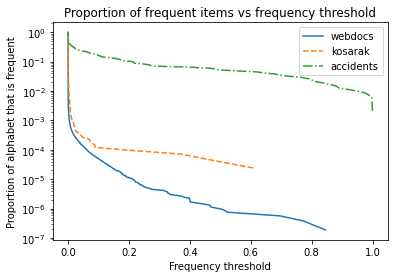

In [7]:
# PLOT RESULTS
'''
* We will plot the farction of the alphabet which is frequenct vs the threshold frequency thres
* To achieve this we ran the exact frequent items algorithm on the three datasets with the 
  threshold equal to zero so we got the exact frequency of every item
* Each frequency will end up being an x coordinate of a point on the graph where the number 
  of items with a frequency greater or equal to that frequency divided by the dataset size 
  is the y coordinate.
* Since the output is sorted in descending order, we will plot the most frequent item with the
  point (freq1, 1/dsize). The next point will be (freq2, 2/dsize). All until (freq_smallest, dsize/dsize).
'''

# the following lists will store x and y axis variables for the 3 datasets
x1 = []
y1 = []

x2 = []
y2 = []

x3 = []
y3 = []

# store size of the alphabet
# this is the len of the output
size1 = len(output1)
# this counter helps determine farction to plot on y axis
counter = 1
# loop thru the output, each output is a point 
for freq in output1:
    # append the frequency as the x coordinate for the point
    x1.append(freq[1])
    # append the number of items with a greater frequency over size as y coordinate
    y1.append(counter/size1)
    # increment counter
    counter += 1

# same method as previous dataset
size2 = len(output2)
counter = 1
for freq in output2:
    x2.append(freq[1])
    y2.append(counter/size2)
    counter += 1

# same method as previous dataset
size3 = len(output3)
counter = 1
for freq in output3:
    x3.append(freq[1])
    y3.append(counter/size3)
    counter += 1


# plot the three lines with different styles (colors automatic)
# label each line for legend
plt.plot(x1,y1, label="webdocs", linestyle="-")
plt.plot(x2,y2, label="kosarak", linestyle="--")
plt.plot(x3,y3, label="accidents", linestyle="-.")
# give plot a title and label each axis
plt.title("Proportion of frequent items vs frequency threshold")
plt.xlabel("Frequency threshold")
plt.ylabel("Proportion of alphabet that is frequent")
# make y axis a log scale
plt.yscale("log")
# show legend and then plot
plt.legend()
plt.show()

### Evaluation on the exact algorithm graph

Here we notice a trend that the proportion of items that are frequent gets smaller as the frequency threshold increases. The three lines on the plot also show that the proportion drops most rapidly at low frequencies and the change begins to level off at higher frequency thresholds. This suggests that there are many items with low frequencies and few items of high frequency so small changes at high threshold frequencies make much smaller impacts than small changes at low threshold frequencies. This is to be expected as in real world data, only a few items or actors in a network tend to be at the highest values. We saw this when studying networks where nodes of high degree were far less common than nodes of low degree. And for the two larger datasets (Kosarak and Webdocs) we see a distribution similar to that of the power-law degree distribution of real world networks. 

We do see a difference between the datasets in variability. There is a far greater proportion of high frequency items in the accidents dataset compared to the other two and the "tail" of its graph is fatter than the others. We can see with Kosarak that there is not even an item with a frequency greater than about 0.6 whereas accidents has an item with a frequency nearly 1, even webdocs has a 0.8+ frequency item. Regardless, each dataset eventually leads to having zero frequent items as the frequency threshold approaches 1. However, this doesn't mean that this has to happen. Theoretically all items could have a frequency of 1, but as these datasets show, in real world data there tend to be fewer high frequency items than low frequency items on any interval in [0,1]. 


### Analyzing the sampling algorithm using the accidents dataset
In the next cell we will run the sampling algorithm over different sample sizes on the accidents dataset and compare its performance to the exact algorithm and theoretical expectations of epsiolon approximations. 

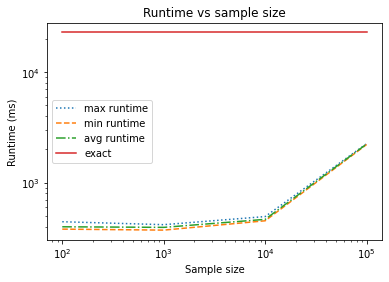

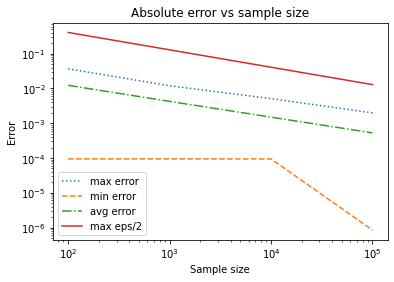

In [8]:
# ANALYZE SAMPLING ALGORITHM
'''
* Here we will analyze two things on the accidents dataset: runtime 
  and error vs error bound.
* We collect all the data simultaneously to avoid unecessary runs
* The sampling algorithm is run 5 times for each sample size (we 
  default have 4 sample size, but this can be changed simply by
  altering the ssizes list to include more ints)
* For each run, the output, runtime, and eps is stored
* After the 5 runs for each sample size; the max, min, and avg
  runtimes are stored; the max epsilon is stored; and the output
  is stored in three places (each a separate copy to avoid overwriting)
* Next the exact algorithm is run twice with threshold thres and 
  thres-epsilon
* Then we subtract the output from the exact run from each output of 
  each sampling runs and take the absolute value to get absolute error
* The max, min, and avg are then calculated for each run, and then for 
  each sample size for every frequent item and stored. These will be plotted.
* The max, min, and avg runtimes are then plotted on a log-log graph and compared
  to the exact algorithm runtime
* Then the absolute errors are plotted vs the epsilon/2 theoretical error bound
'''

# parameters that determine sample size and threshold
thres = 0.8
ssizes = [100,1000,10000,100000]

# lists to store max, min, avg runtimes
max_runs = []
min_runs = []
avg_runs = []
# list to store max eps values
max_eps_runs = []
# lists to store max, min, avg abs errors
max_err_runs = []
min_err_runs = []
avg_err_runs = []

# loop thru each sample size
for ssize in ssizes:
    # create temporary lists to store values from runs on this sample size
    runtimes = []
    epss = []
    max_outputs = []
    min_outputs = []
    avg_outputs = []

    # run the sampling algorithm 5 times for each sample size
    for run in range(0,5):

        # run the sampling algorithm
        runtime,eps,output = sample_freq_items(ssize, dsize3, 0.1, thres, accidents)

        # add runtime and eps value to corresponding lists
        runtimes.append(runtime)
        epss.append(eps)

        # get frequencies from the outputs
        outputs = [item[1] for item in output]
        # store a copy of the frequencies in each of max, min, avg outputs
        # needs copies otherwise future calculation are done on same list
        max_outputs.append(outputs.copy())
        min_outputs.append(outputs.copy())
        avg_outputs.append(outputs.copy())

    # calculate and store max, min, and avg runtimes for this sample size
    max_runs.append(max(runtimes))
    min_runs.append(min(runtimes))
    avg_runs.append(mean(runtimes))
    # calculate and store max epsilon value for this sample size
    max_eps_runs.append(max(epss))

    # add outputs for this sample size to abs error lists
    max_err_runs.append(max_outputs)
    min_err_runs.append(min_outputs)
    avg_err_runs.append(avg_outputs)
    
# run the exact algorithm twice with thres and thres - epsilon
# use max epsilon from smallest samnple size for second run
output, runtime_eps, dsize = exact_freq_items(thres, accidents)
output_eps2, runtime_eps2, dsize_eps2 = exact_freq_items(thres-max_eps_runs[0], accidents)

# loop thru all ouputs to calculate abs errors then find max, min, avg
# loop thru sample sizes
for i in range(0,len(ssizes)):
    # loop thru each of 5 runs
    for j in range(0,5):
        # loop thru each frequent item outputted
        for k in range(0, len(max_err_runs[i][j])):
            # subtract exact algorithm ouput from sample output and take abs value
            max_err_runs[i][j][k] = abs(max_err_runs[i][j][k] - output_eps2[k][1])
            min_err_runs[i][j][k] = abs(min_err_runs[i][j][k] - output_eps2[k][1])
            avg_err_runs[i][j][k] =abs(avg_err_runs[i][j][k] - output_eps2[k][1])

        # calulcate max, min, avg abs error of each individual run
        # then store it in place of the run output list
        max_err_runs[i][j] = max(max_err_runs[i][j])
        min_err_runs[i][j] = min(min_err_runs[i][j])
        avg_err_runs[i][j] = mean(avg_err_runs[i][j])

    # calculate the max, min, avs abs error for each sample size
    # then store it in place of sample size output list
    max_err_runs[i] = max(max_err_runs[i])
    min_err_runs[i] = min(min_err_runs[i])
    avg_err_runs[i] = mean(avg_err_runs[i])
        
# Plot the lines for the runtimes of the sampling algorithm
plt.plot(ssizes, max_runs, label="max runtime", linestyle=":")
plt.plot(ssizes, min_runs, label="min runtime", linestyle="--")
plt.plot(ssizes, avg_runs, label="avg runtime", linestyle="-.")
# plot a horizontal line of exact runtime
plt.plot([ssizes[0],ssizes[-1]], [runtime_eps, runtime_eps], label="exact", linestyle="-")
# give plot a title and axis labels
plt.title("Runtime vs sample size")
plt.xlabel("Sample size")
plt.ylabel("Runtime (ms)")
# give both axes a log scale
plt.xscale("log")
plt.yscale("log")
# show legend and plot
plt.legend()
plt.show()

# plot the max, min, and avg error for each sample size
plt.plot(ssizes, max_err_runs, label="max error", linestyle=":")
plt.plot(ssizes, min_err_runs, label="min error", linestyle="--")
plt.plot(ssizes, avg_err_runs, label="avg error", linestyle="-.")
# divide max eps by 2 for all sample sizes and plot them as a line
max_eps_runs2 = [x/2 for x in max_eps_runs]
plt.plot(ssizes, max_eps_runs, label="max eps/2", linestyle="-")
# give plot a title and axis labels
plt.title("Absolute error vs sample size")
plt.xlabel("Sample size")
plt.ylabel("Error")
# give both axes a log scale
plt.xscale("log")
plt.yscale("log")
# show legend and plot
plt.legend()
plt.show()


### Evaluate of the sampling algorithm graphs
We can see on the plot of absolute error vs sample size that all three of the max, min, and mean absolute error decrease as the sample size gets larger. This is also shown on a log scale so the decrease in error is quite significant as well. However, it must be noted that the runtime does significantly increase as the sample size gets larger. And the runtime increase, also on a log scale, is a greater increase than the decrease in error seen. Further, when evaluating the error, our max observed absolute error is always less than the theoretical error bound of epsilon/2. This means that for all the sample sizes tested in the range 100 to 100 000, we get an epsilon approximation and we can make solid assertions about the results. The low absolute error also shows that the frequencies can considered as good approximations of the exact values, although they are still not exact values. Overall, I'd estimate the best trade off to be a sample in the 1000 to 10 000 range in terms of runtime vs error. Especially for a dataset that is significantly larger than the ones used here, the nonlinear increase in runtime will cause more issues for increasingly more insignificant improvements in accuracy.

This is all holds at least for high frequency items. It makes sense that approximations of high frequency items are easier than low frequency items because they are far less likely to be missed by random samples of the dataset. So the fact we're using a frequency threshold of 0.8 here means that the error will be relatively low as all the items are very common and thus will be very present in the random samples. That being said, in practice the most frequent items are the ones of most interest and approximation algorithms are made to be used in practice so this optimal performance on the most frequent items is good. In the end, these results show that in practice the sampling algorithm is very very good at getting the frequent items of a dataset and it can be run many times in the time it takes to run the exact algorithm once. 

 